# Neural Networks for Classification

## 1. Make classification data

In [464]:
from sklearn.datasets import make_circles, make_blobs
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from sklearn.model_selection import train_test_split

In [465]:
n_samples = 1000
X, y = make_circles(n_samples,
                    noise=0.05,
                    random_state=816)

In [466]:
print(f'First 5 X\'s: {X[:5]}')
print(f'First 5 y\'s: {y[:5]}')

First 5 X's: [[ 1.01847104 -0.15775217]
 [ 0.38386256  0.7339668 ]
 [ 0.72060905 -0.64467351]
 [ 0.88025312  0.52538544]
 [ 0.96620164 -0.10357839]]
First 5 y's: [0 1 0 0 0]


In [467]:
circles = pd.DataFrame({'X1': X[:, 0],
                        'X2': X[:, 1],
                        'labels': y
                        })

In [468]:
circles.head()

,X1,X2,labels
0,1.018471,-0.157752,0
1,0.383863,0.733967,1
2,0.720609,-0.644674,0
3,0.880253,0.525385,0
4,0.966202,-0.103578,0


In [469]:
circles.labels.value_counts()

labels
0    500
1    500
Name: count, dtype: int64

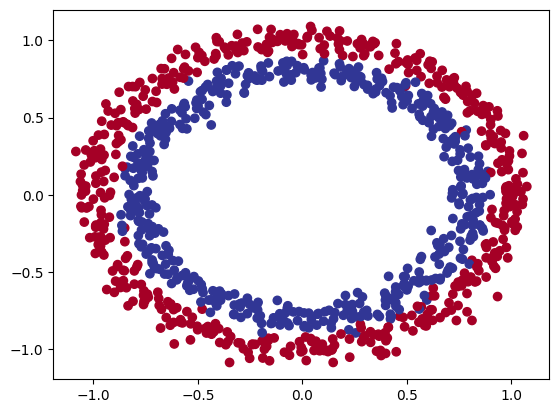

In [470]:
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)

In [471]:
X.shape

(1000, 2)

In [472]:
y.shape

(1000,)

In [473]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [474]:
X[:5]

tensor([[ 1.0185, -0.1578],
        [ 0.3839,  0.7340],
        [ 0.7206, -0.6447],
        [ 0.8803,  0.5254],
        [ 0.9662, -0.1036]])

In [475]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=816)

In [476]:
len(X_train), len(X_test)

(800, 200)

## 2. Model Building
1. Set up device-agnostic code
2. Construct a model
3. Define a loss function
4. Create a training loop

In [477]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [478]:
class CircleClassifierV01(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=5)
        self.layer_2 = nn.Linear(in_features=5, out_features=1)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        return self.layer_2(self.layer_1(X))

In [479]:
model_0 = CircleClassifierV01().to(device)
model_0

CircleClassifierV01(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [480]:
untrained_pred = model_0(X_test.to(device))
print(f'Untrained Predictions: {untrained_pred[:10]}')
print(f'True Labels: {y_test}')

Untrained Predictions: tensor([[0.1246],
        [0.2257],
        [0.1729],
        [0.2680],
        [0.0324],
        [0.2829],
        [0.0592],
        [0.1607],
        [0.2714],
        [0.0131]], grad_fn=<SliceBackward0>)
True Labels: tensor([1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1.,
        0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
        0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
        0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 0.,
        1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0.,
        1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
        0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0.,
        0., 1., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 1., 1., 0., 1., 0.,
        0., 1., 1., 1., 0., 0., 1., 0

In [481]:
loss_func = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model_0.parameters(),
                         lr=0.01)

In [482]:
y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[0.1246],
        [0.2257],
        [0.1729],
        [0.2680],
        [0.0324]], grad_fn=<SliceBackward0>)

In [483]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5311],
        [0.5562],
        [0.5431],
        [0.5666],
        [0.5081]], grad_fn=<SigmoidBackward0>)

In [484]:
y_pred = torch.round(y_pred_probs)
y_pred

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.]], grad_fn=<RoundBackward0>)

## 3. Training Loop

In [485]:
def accuracy_func(y_true, y_pred):
    correct = torch.eq(y_pred, y_true).sum().item()
    acc = (correct / len(y_true)) * 100
    return acc

In [486]:
torch.manual_seed(816)

epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model_0.train()

    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_func(y_logits, y_train)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model_0.eval()
    with torch.inference_mode():
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_func(test_logits, y_test)
        # test_acc = accuracy_func(y_test, test_pred)

        if epoch % 10 == 0:
            print(f'Epoch: {epoch}',
                  f'Loss: {loss:.5f}',
                  f'Test Loss: {test_loss:.5f}')

Epoch: 0 Loss: 0.69571 Test Loss: 0.70361
Epoch: 10 Loss: 0.69551 Test Loss: 0.70317
Epoch: 20 Loss: 0.69532 Test Loss: 0.70276
Epoch: 30 Loss: 0.69515 Test Loss: 0.70238
Epoch: 40 Loss: 0.69500 Test Loss: 0.70203
Epoch: 50 Loss: 0.69486 Test Loss: 0.70170
Epoch: 60 Loss: 0.69474 Test Loss: 0.70139
Epoch: 70 Loss: 0.69463 Test Loss: 0.70111
Epoch: 80 Loss: 0.69452 Test Loss: 0.70084
Epoch: 90 Loss: 0.69443 Test Loss: 0.70058


In [487]:
class CircleClassifierV02(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(X)))))

In [488]:
model_1 = CircleClassifierV02().to(device)
print(model_1)

CircleClassifierV02(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


Question: Where should I put the non-linear activation functions when constructing a neural network?

A rule of thumb is to put them in between hidden layers and just after the output layer, however, there is no set in stone option. As you learn more about neural networks and deep learning you'll find a bunch of different ways of putting things together. In the meantime, best to experiment, experiment, experiment.

In [489]:
loss_func = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_1.parameters(),
                            lr=0.01)

In [490]:
torch.manual_seed(816)
epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # 1. Forward Pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # 2. Calculate Loss
    loss = loss_func(y_logits, y_train)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss Backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    model_1.eval()
    with torch.inference_mode():
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_func(test_logits, y_test)

    if epoch % 10 == 0:
        print(f'Epoch: {epoch}'
              f'Train Loss: {loss}'
              f'Test Loss: {test_loss}')

Epoch: 0Train Loss: 0.7016586065292358Test Loss: 0.7121286988258362
Epoch: 10Train Loss: 0.7010742425918579Test Loss: 0.7112369537353516
Epoch: 20Train Loss: 0.7005205750465393Test Loss: 0.7103843688964844
Epoch: 30Train Loss: 0.6999925374984741Test Loss: 0.7095710635185242
Epoch: 40Train Loss: 0.699490487575531Test Loss: 0.7087948322296143
Epoch: 50Train Loss: 0.6990174651145935Test Loss: 0.7080521583557129
Epoch: 60Train Loss: 0.6985688805580139Test Loss: 0.7073397040367126
Epoch: 70Train Loss: 0.6981436014175415Test Loss: 0.7066584825515747
Epoch: 80Train Loss: 0.6977367997169495Test Loss: 0.7060084342956543
Epoch: 90Train Loss: 0.6973516941070557Test Loss: 0.7053860425949097
Epoch: 100Train Loss: 0.6969830393791199Test Loss: 0.704786479473114
Epoch: 110Train Loss: 0.6966252326965332Test Loss: 0.7042065262794495
Epoch: 120Train Loss: 0.696281909942627Test Loss: 0.703643262386322
Epoch: 130Train Loss: 0.695954442024231Test Loss: 0.7030953764915466
Epoch: 140Train Loss: 0.695644557476

# Multi-class Classification

In [491]:
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 618

X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5,
                            random_state=RANDOM_SEED)

In [492]:
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

X_train, X_test, y_train, y_test = train_test_split(X_blob, y_blob, test_size=0.2, random_state=RANDOM_SEED)

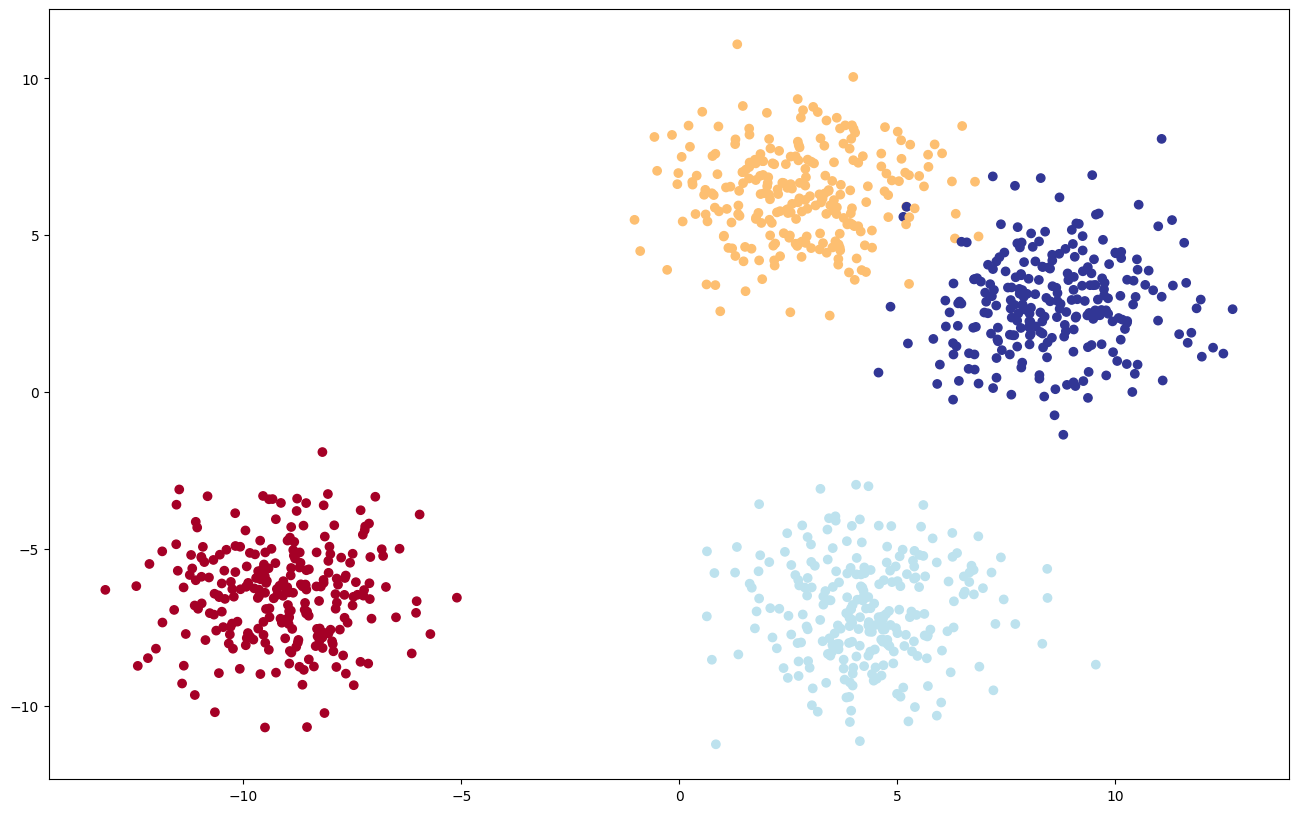

In [493]:
plt.figure(figsize=(16, 10))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)

In [494]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [495]:
input_features = 2
output_features = 4
hidden_neurons = 8

In [496]:
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_features=8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_features),
            nn.Linear(in_features=hidden_features, out_features=hidden_features),
            nn.Linear(in_features=hidden_features, out_features=output_features)
        )
    def forward(self, X: torch.Tensor) -> torch.Tensor:
        return self.linear_layer_stack(X)

In [497]:
model_2 = BlobModel(NUM_FEATURES, NUM_CLASSES, hidden_neurons).to(device)
model_2

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [498]:
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_2.parameters(),
                            lr=0.1)

In [499]:
torch.manual_seed(RANDOM_SEED)

epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model_2.train()

    y_logits = model_2(X_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

    loss = loss_func(y_logits, y_train)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model_2.eval()
    with torch.inference_mode():
        test_logits = model_2(X_test)
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

        test_loss = loss_func(test_logits, y_test)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test Loss: {test_loss:.5f}")



Epoch: 0 | Loss: 1.26429 | Test Loss: 0.61511
Epoch: 10 | Loss: 0.12288 | Test Loss: 0.10788
Epoch: 20 | Loss: 0.06348 | Test Loss: 0.06635
Epoch: 30 | Loss: 0.04645 | Test Loss: 0.05240
Epoch: 40 | Loss: 0.03851 | Test Loss: 0.04584
Epoch: 50 | Loss: 0.03402 | Test Loss: 0.04211
Epoch: 60 | Loss: 0.03118 | Test Loss: 0.03976
Epoch: 70 | Loss: 0.02924 | Test Loss: 0.03816
Epoch: 80 | Loss: 0.02785 | Test Loss: 0.03701
Epoch: 90 | Loss: 0.02681 | Test Loss: 0.03615


In [500]:
try:
    from torchmetrics import Accuracy
except:
    !pip install torchmetrics==0.9.3
    from torchmetrics import Accuracy

# Setup metric and make sure it's on the target device
torchmetrics_accuracy = Accuracy(task='multiclass', num_classes=4).to(device)

# Calculate accuracy
torchmetrics_accuracy(test_pred, y_test)

tensor(0.9850)